# SLT-CE-2: Sampling

# Introduction

## Task

In this coding exercise we will test various MCMC sampling procedures [1] introduced during the tutorial session. We will try to solve the image reconstruction problem. Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one needs to recover the original through denoising. To do so we will use the prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from physics as explained in section 8.3.3 of [2]. An undirected graphical model is designed to model (i) the adherence of the reconstruction to the observed noisy image and (ii) the correlation between neighboring pixels. We are interested in recovering a single image, the most likely one, with respect to the underlying distribution i.e. we do MAP inference to discover the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is the value of the i-th pixel, the Ising model tries to find a denoised image $x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x,y) = - h \sum_{i} x_i - \beta \sum_{i,j \in N_i} x_i x_j - \eta \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel neighbourhood $N_i$ usually involves 4 or 8 surrounding pixels. You should try out both options during this exercise, and see which one works better. The undirected probabilistic graphical model from where the energy function $E(x,y)$ is derived is in more detail explained in [2].

## Setup

We start by importing necessary python packages.

In [660]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pylab as plt
from scipy.ndimage import convolve
import time
import copy

We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [661]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [662]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

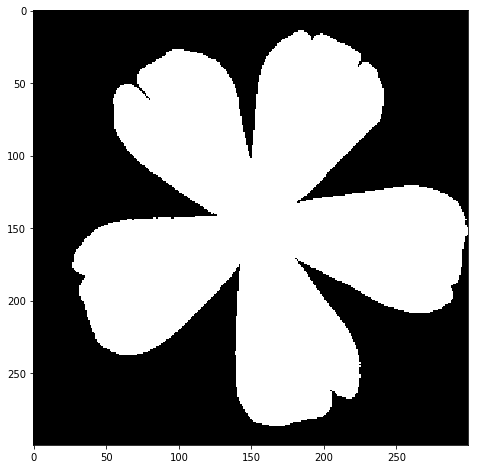

In [663]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [664]:
# Fix random seed for reproducibility
np.random.seed(13)

IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.3 * IMG_ORIGINAL.size)]
for k in perm:
    i = int(k/IMG_WIDTH)
    j = k%IMG_HEIGHT
    IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]

Plot the noisy version of the original image

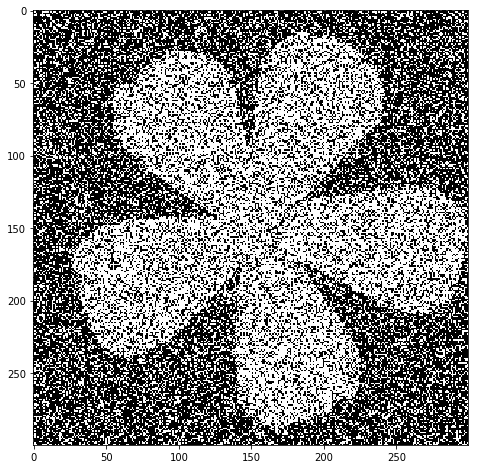

In [665]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

Finally, in this exercise we do not care about learning the right model from the data, but only about inferring the most likely state, the one with the minimum energy. Thus we will fix parameters of the model as given in [2].

In [666]:
H = 0.0
Beta = 1.0
Eta = 2.1

# Problems:

Solve all the problems to get 1 point, and an extension at the end of the notebook to get an extra point. Note that above all, we will validate the working code. If most of the exercise is successfully completed you will be fully compensated. In addition, make sure that all the code can be executed in a reasonable time meaning approx. less than 2mins, otherwise you might want to do some changes in your implementation.

## Problem 0

Shortly describe, in a few sentences, and give the corresponding formulas for the following sampling procedures which you will be consequently trying to implement in the rest of this exercise. Add text in each bullet. See [markdown cheatsheet](https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed) for text editing.
### Metropolis
The Metropolis algorithm can be used to obtain samples from a probability distribution $p(.)$ for which getting samples would be expensive otherwise. The general idea is that we draw samples from a cheaper and suitable(!) proposal distribution $q(x^*|x)$. In each step, we get an $x^*$ based on the current state $x$. This new $x*$ is then accepted as a sample with probability $min\{1,\frac{p(x^*)q(x^{(i)}|x^*)}{p(x^{(i)})q(x^*|x^{(i)})}\}$

We can adapt this algorithm for the given problem as follows:
1. Given image $x$, we select a random pixel $p_{i,j}$ and flip it to obtain a new image $y$
2. We evaluate energy difference between the new and the old image: $\Delta E = E(y) - E(x)$
3. If $\Delta E < 0$ the new image is accepted. Otherwise the image is accepted with probability: $p = e^{-\Delta E/T}$.

### Heat Bath:
The heat bath algorithm is a variation of the metropolis sampling. The only difference being the acceptance probability which for this algorithm is $$p = \frac{e^{-\beta \Delta E}}{e^{-\beta \Delta E} + 1}$$
### Simulated Annealing
Simulated Annealing is an adaptation of the Metropolis-Algorithm for the use case in which we want to find the maximum of some function $p(x)$ rather than its integral or expected value. 

In this case the acceptance probability is given by $$ p= min\{1,\frac{p^{1/T_i}(x^*)q(x^{(i)}|x^*)}{p^{1/T_i}(x^{(i)})q(x^*|x^{(i)})}\}$$
### Parallel Tempering
Very roughly, parallel tempering consist of running multiple metropolis samplers in parallel. The different models swap their temperatures at each timestep with some non-zero probability p (0.1 in my implementation). At the end of the run, the results of the models are aggregated, which I did using majority voting, i.e. each pixel is set to the value it has in the majority of the models that ran. 

## Problem 1

Firstly, to be able to search for the state which minimizes the energy of our model, we need to be able to compute the energy. This is done with respect to the model described at the beginning of the notebook. We also want to have a certain quantification of our reconstruction, to measure how far is our reconstruction estimate from the original. For this, we will use [Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error). Implement the two following functions. Also feel free to add any additional auxilary functions which will be used in the rest of the exercise.

In [667]:
def energy(img_estimate, img_noisy_observation, changed_pixel=None):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', vector y in the model.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    
    image_dimensions = img_estimate.shape
    
    if changed_pixel is not None:
        i,j = changed_pixel
        x_sum = img_estimate[i,j]
        neighbor_sum = 0
        if (i - 1 > 0):
            neighbor_sum += img_estimate[i,j] * img_estimate[i - 1,j]
        if (i + 1 < image_dimensions[0]):
            neighbor_sum += img_estimate[i,j] * img_estimate[i + 1,j]
        if (j - 1 > 0):  
            neighbor_sum += img_estimate[i,j] * img_estimate[i,j - 1]
        if (j + 1 < image_dimensions[1]):
            neighbor_sum += img_estimate[i,j] * img_estimate[i,j + 1]
        if (j + 1 < image_dimensions[1] and i + 1 < image_dimensions[0]):
            neighbor_sum += img_estimate[i,j] * img_estimate[i + 1,j + 1]
        if (j + 1 < image_dimensions[1] and  i - 1 > image_dimensions[0]):
            neighbor_sum += img_estimate[i,j] * img_estimate[i - 1,j + 1]
        if (j - 1 > 0 and i - 1 > 0):
            neighbor_sum += img_estimate[i,j] * img_estimate[i - 1,j - 1]
        if (j - 1 > 0 and i + 1 < image_dimensions[0]):
            neighbor_sum += img_estimate[i,j] * img_estimate[i + 1,j - 1]
        
        x_y_sum = img_estimate[i,j]*img_noisy_observation[i,j]
    
    else:
        x_sum = np.sum(np.sum(img_estimate,axis=0))
        neighbor_sum = 0
        for i in range(image_dimensions[0]):
            for j in range(image_dimensions[1]):
                if (i - 1 > 0):
                    neighbor_sum += img_estimate[i,j] * img_estimate[i - 1,j]
                if (i + 1 < image_dimensions[0]):
                    neighbor_sum += img_estimate[i,j] * img_estimate[i + 1,j]
                if (j - 1 > 0):  
                    neighbor_sum += img_estimate[i,j] * img_estimate[i,j - 1]
                if (j + 1 < image_dimensions[1]):
                    neighbor_sum += img_estimate[i,j] * img_estimate[i,j + 1]

        x_y_sum = 0
        for i,j in zip(range(image_dimensions[0]),range(image_dimensions[1])):
            x_y_sum += img_estimate[i,j]*img_noisy_observation[i,j]

    energy = -H*x_sum - Beta*neighbor_sum - Eta*x_y_sum

    return energy

In [668]:
def mse_loss(img_estimate, img_original,pixel_to_check=None):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    if pixel_to_check is not None:
        i,j = pixel_to_check
        if img_estimate[i,j] == img_original[i,j]:
            mse = 0
        else:
            mse = 4.0/np.power(img_estimate.shape[0],2)
    else:
        image_dimensions = img_estimate.shape
        number_of_pixels = image_dimensions[0] * image_dimensions[1]
        sum = 0.0
        for i in range(image_dimensions[0]):
            for j in range(image_dimensions[1]):
                sum += np.power((img_estimate[i,j] - img_original[i,j]),2)

        mse = sum/number_of_pixels
    return mse

In [669]:
# Any auxiliary functions may be placed here..
def get_random_index(upper_bound=None):
    if upper_bound is None:
        upper_bound = 300
    return np.random.randint(0,upper_bound)

def shuffle_temperatures(temperatures):
    """Returns a reordered list of temperatures. To be used in parallel tempering."""
    shuffled_temperatures = [x for x in temperatures]
    for i in range(len(temperatures)):
        u = np.random.uniform()
        if u < 0.1:
            j = np.random.randint(0,len(temperatures))
            shuffled_temperatures[j] = temperatures[i]
            shuffled_temperatures[i] = temperatures[j]
        else:
            shuffled_temperatures[i] = temperatures[i]
    return shuffled_temperatures
    

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [670]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))

1.2
-350735.2
-57524.0


## Problem 2

Implement metropolis sampling.

In [671]:
def metropolis(img_noisy_observation, img_original, epochs, acceptance_function="metropolis"):
    """Do the metropolis sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    best_reconstruction = []
    best_losses = []
    LARGE_FAKE_ENERGY = 1000000000
    DELTA_LOSS = 4.0/np.power(img_noisy_observation.shape[0],2)
    NUMBER_OF_SAMPLES = 200000
    best_energies = [LARGE_FAKE_ENERGY]
    
    # I use epochs in the following sense: In each epoch, we run the system for NUMBER_OF_SAMPLES times.
    # We select the reconstruction from the epoch with the lowest energy in the final state. 
    for e in range(epochs):
        energies = []
        losses = []
        E = energy(img_noisy_observation, img_noisy_observation)
        L = mse_loss(img_noisy_observation, img_original)
        energies.append(E)
        losses.append(L)

        current_image = copy.copy(img_noisy_observation)
        
        # Initialize the temperature 
        T = 10
        k_B = 1.0
        temp_image = np.zeros(current_image.shape)
        for e in range(1, NUMBER_OF_SAMPLES):

            # get random indices for pixel. flip that pixel
            i = get_random_index()
            j = get_random_index()

            temp_image[i-1:i+2,j-1:j+2] = current_image[i-1:i+2,j-1:j+2]
            temp_image[i,j] = -1*temp_image[i,j]

            # Evaluate Energy
            delta_E = 2*energy(temp_image, current_image,(i,j))
            E = energies[e - 1] + min(delta_E,0)

            # Decide whether we accept it, or reject it
            if delta_E <= 0:
                current_image[i,j] = current_image[i,j]*-1

                pixel_loss = mse_loss(current_image, img_original,(i,j))
                if pixel_loss == 0:
                    L = losses[-1] - DELTA_LOSS
                else: 
                    L = losses[-1] + DELTA_LOSS

            else:
                if acceptance_function == "metropolis":
                    p = np.exp(-delta_E/(k_B*T))
                elif acceptance_function == "heat_bath":
                    beta = 1
                    p = np.exp(-beta*delta_E)/(np.exp(-beta*delta_E) + 1)
                elif acceptance_function == "simulated_annealing":
                    p = np.exp(-delta_E/(k_B*T))
                    p = np.power(p,1/T)
                    
                u = np.random.uniform()
                if u < p:
                    
                    current_image[i,j] = current_image[i,j]*-1
                    pixel_loss = mse_loss(current_image, img_original,(i,j))
                    if pixel_loss == 0:
                        L = losses[-1] - DELTA_LOSS
                    else: 
                        L = losses[-1] + DELTA_LOSS
                else:
                    L = losses[-1]

            T = 0.9*T

            # Measure loss
            energies.append(E)
            losses.append(L)
        if energies[-1] < best_energies[-1]:
            best_reconstruction = current_image
            best_losses = losses
            best_energies = energies

    return best_reconstruction, np.asarray(best_energies), np.asarray(best_losses)

## Problem 3

Implement heath bath sampling.

In [672]:
def heathbath(img_noisy_observation, img_original, epochs):
    """Do the heath bath sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    reconstruction, energies, losses = metropolis(img_noisy_observation, img_original, epochs, "heat_bath")
        
    return reconstruction, energies, losses

## Problem 4

Implement simulated annealing.

In [673]:
def simulated_annealing(img_noisy_observation, img_original, epochs):
    """Do the simulated annealing sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    reconstruction, energies, losses = metropolis(img_noisy_observation, img_original, epochs, "simulated_annealing")
        
    return reconstruction, energies, losses

## Problem 5

Implement parallel tempering

In [682]:
def parallel_tempering(img_noisy_observation, img_original, epochs):
    """Do the parallel tempering sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    NUMBER_OF_RANDOM_WALKERS = 3
    TIMESTEPS = 20000
    DELTA_LOSS = 4.0/np.power(img_noisy_observation.shape[0],2)
    
    energies = np.zeros((NUMBER_OF_RANDOM_WALKERS, TIMESTEPS))
    losses = np.zeros((NUMBER_OF_RANDOM_WALKERS, TIMESTEPS))
    E = energy(img_noisy_observation, img_noisy_observation)
    L = mse_loss(img_noisy_observation, img_original)
    energies[:,0] = E
    losses[:,0] = L
    current_images = {}
    for i in range(NUMBER_OF_RANDOM_WALKERS):
        current_images[i] = copy.copy(img_noisy_observation)
    
    # Initialize the temperature 
    T = np.zeros((NUMBER_OF_RANDOM_WALKERS,TIMESTEPS))
    T[:,0] = [1,2,3]
    k_B = 1.0
    temp_image = np.zeros(current_images[0].shape)
    for e in range(1, TIMESTEPS):
        for w in range(NUMBER_OF_RANDOM_WALKERS):

            # get random indices for pixel. flip that pixel
            i = get_random_index()
            j = get_random_index()

            temp_image[i-1:i+2,j-1:j+2] = current_images[w][i-1:i+2,j-1:j+2]
            temp_image[i,j] = -1*temp_image[i,j]

            # Evaluate Energy
            delta_E = 2*energy(temp_image, current_images[w],(i,j))

            E = energies[w,e - 1] + min(delta_E,0)

            # Decide whether we accept it, or reject it
            if delta_E <= 0:
                current_images[w][i,j] = current_images[w][i,j]*-1

                pixel_loss = mse_loss(current_images[w], img_original,(i,j))
                if pixel_loss == 0:
                    L = losses[w, e -1] - DELTA_LOSS
                else: 
                    L = losses[w, e -1] + DELTA_LOSS

            else:
                p = np.exp(-delta_E/(k_B*T[w, e-1]))        
                u = np.random.uniform()

                if u < p:
                    
                    current_images[w][i,j] = current_images[w][i,j]*-1
                    pixel_loss = mse_loss(current_images[w], img_original,(i,j))
                    if pixel_loss == 0:
                        L = losses[w,e-1] - DELTA_LOSS
                    else: 
                        L = losses[w,e-1] + DELTA_LOSS
                else:
                    L = losses[w,e-1]

            T = 0.9*T

            # Measure loss
            energies[w,e] = E
            losses[w,e] = L
        
        T[:,e] = shuffle_temperatures(T[:,e-1])
    
    # We aggregate the different states of the walkers through a majority vote.
    
    average_image = np.zeros(img_original.shape)
    for key in current_images:
        average_image = np.add(average_image, current_images[key])
    average_image = average_image/float(len(current_images))
    average_image[average_image < 0] = -1.0
    average_image[average_image > 0] = 1.0
        
    return average_image, np.asarray(np.average(energies, axis=0)), np.asarray(np.average(losses, axis=0))

## Problem 6

We provide you with a function which is used to evaluate the performance of your implementation, both in terms of time efficency and the quality of image reconstruction. In addition, we plot the energy and mean squared error loss recorded during sampling procedure. Make sure your implementation is giving reasonable estimates in a reasonable time.

In [675]:
def evaluate(method, img_noisy_observation, img_original, epochs=1, method_arguments=None):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    if method_arguments is None:
        img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs)
    else:
        img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs, method_arguments)
        
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

Evaluate metropolis

/Users/lorenz/miniconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars


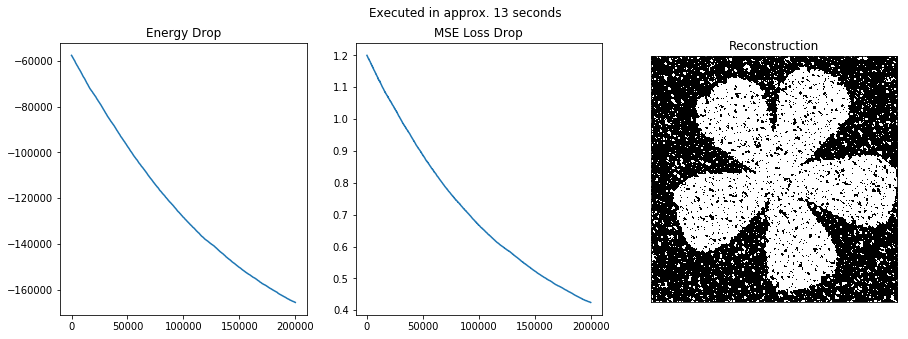

CPU times: user 13.4 s, sys: 235 ms, total: 13.7 s
Wall time: 13.8 s


In [676]:
%%time
# The sampling process will be run $epoch many times. The best reconstruction from these runs 
# according to the energy in the final state will be chosen. 
# The NUMBER_OF_TIMESTEPS can be set in the metropolis function above.  
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 1, "metropolis")

Evaluate heathbath

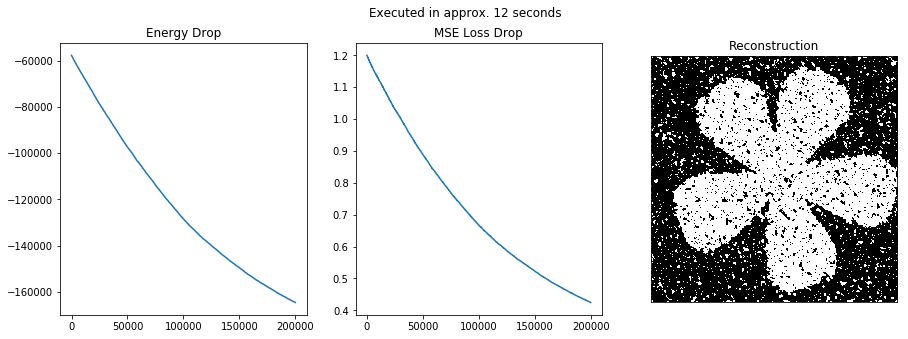

CPU times: user 12.8 s, sys: 280 ms, total: 13.1 s
Wall time: 13.8 s


In [677]:
%%time
evaluate(heathbath, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 1)

Evaluate simulated annealing

/Users/lorenz/miniconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars


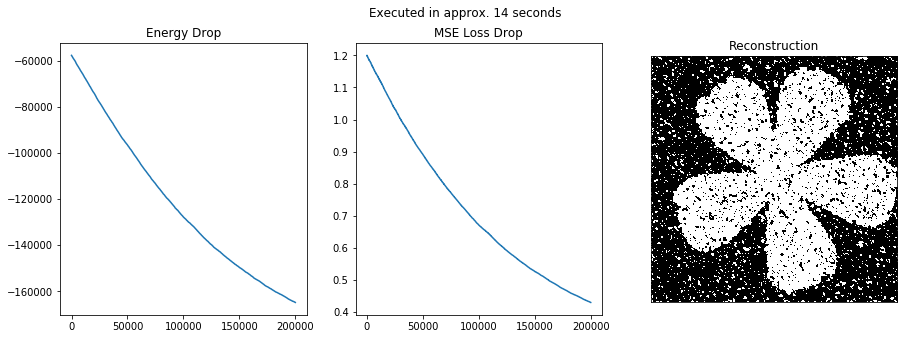

CPU times: user 14.5 s, sys: 169 ms, total: 14.7 s
Wall time: 14.9 s


In [678]:
%%time
evaluate(simulated_annealing, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 1)

Evaluate parallel tempering

/Users/lorenz/miniconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in double_scalars


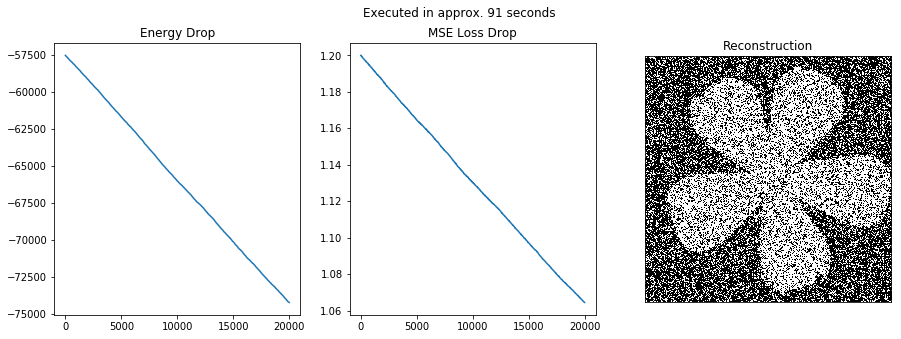

In [684]:
evaluate(parallel_tempering, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 1)

If you have experienced any implementation issues, this is the place to complain. Did you encounter any numerical or efficiency problems? If yes, how did you solve them? Any reasoning is appreciated.

### Your remarks:
I achieved a large speedup by only evaluating the energy and the MSE for the individual pixel that was being changed instead of recomputing it for the entire image. 


## Problem 7

We now ask you to re-implement one of the sampling methods of your choice by changing the algorithm slighly (but not only parameters such as e.g. initial temperature $T$). One can for example, in metropolis scheme try to order the evaluated pixels both sequentually and randomly. Also one can implement the simulated annealing with different annealing schedules: logarithmic, linear, quadratic etc. Explain what you change.

### Variation: Different Annealing Schedules
I test different annealing schedules and evaluate how this impacts the sampling. 
The following functions are tested:
1. Linear: $Temperature_i = -x + T_0$ where $Temperature_i$ is the temperature at the ith time step, x is the sum of timesteps at time i and $T_0$ is the initial temperature. 
2. Quadratic: $Temperature_i = -x^2 + T_0$, with the same variables as above. 
3. Logarithmic: $Temperature_i = -log(x)$

In [685]:
def your_method(img_noisy_observation, img_original, epochs, annealing_mode):
    """Do the sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code

    best_reconstruction = []
    best_losses = []
    LARGE_FAKE_ENERGY = 1000000000
    DELTA_LOSS = 4.0/np.power(img_noisy_observation.shape[0],2)
    NUMBER_OF_TIMESTEPS = 200000
    best_energies = [LARGE_FAKE_ENERGY]
    for e in range(epochs):
        energies = []
        losses = []
        E = energy(img_noisy_observation, img_noisy_observation)
        L = mse_loss(img_noisy_observation, img_original)
        energies.append(E)
        losses.append(L)

        current_image = copy.copy(img_noisy_observation)
        
        # Initialize the temperature 
        T_0 = 8
        k_B = 1.0
        temp_image = np.zeros(current_image.shape)
        
        
        if annealing_mode == "linear":
            times = np.linspace(0,T_0,NUMBER_OF_TIMESTEPS)
            T = [-t + T_0 for t in times]
        elif annealing_mode == "quadratic":
            times = np.linspace(0,np.power(T_0,0.5),NUMBER_OF_TIMESTEPS)
            T = [- t**2 + T_0 for t in times]
        elif annealing_mode == "logarithmic":
            times = np.linspace(0.0000001,1,NUMBER_OF_TIMESTEPS)
            T = [-np.log(t) for t in times]

        for e in range(1, NUMBER_OF_TIMESTEPS):

            # get random indices for pixel. flip that pixel
            i = get_random_index()
            j = get_random_index()

            temp_image[i-1:i+2,j-1:j+2] = current_image[i-1:i+2,j-1:j+2]
            temp_image[i,j] = -1*temp_image[i,j]

            # Evaluate Energy
            delta_E = 2*energy(temp_image, current_image,(i,j))
            E = energies[e - 1] + min(delta_E,0)

            # Decide whether we accept it, or reject it
            if delta_E <= 0:
                current_image[i,j] = current_image[i,j]*-1

                pixel_loss = mse_loss(current_image, img_original,(i,j))
                if pixel_loss == 0:
                    L = losses[-1] - DELTA_LOSS
                else: 
                    L = losses[-1] + DELTA_LOSS

            else:

                p = np.exp(-delta_E/(k_B*T[e]))
                u = np.random.uniform()
                if u < p:
                    
                    current_image[i,j] = current_image[i,j]*-1
                    pixel_loss = mse_loss(current_image, img_original,(i,j))
                    if pixel_loss == 0:
                        L = losses[-1] - DELTA_LOSS
                    else: 
                        L = losses[-1] + DELTA_LOSS
                else:
                    L = losses[-1]


            # Measure loss
            energies.append(E)
            losses.append(L)
        if energies[-1] < best_energies[-1]:
            best_reconstruction = current_image
            best_losses = losses
            best_energies = energies
    plt.figure(figsize=(4,5))
    plt.plot(np.linspace(0,NUMBER_OF_TIMESTEPS,NUMBER_OF_TIMESTEPS),T)
    plt.suptitle("Annealing Schedule")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.show()
    return best_reconstruction, np.asarray(best_energies), np.asarray(best_losses)

/Users/lorenz/miniconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars


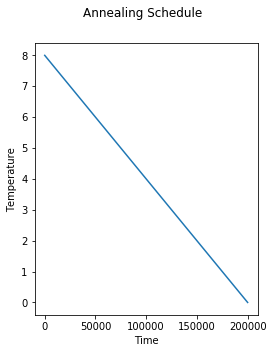

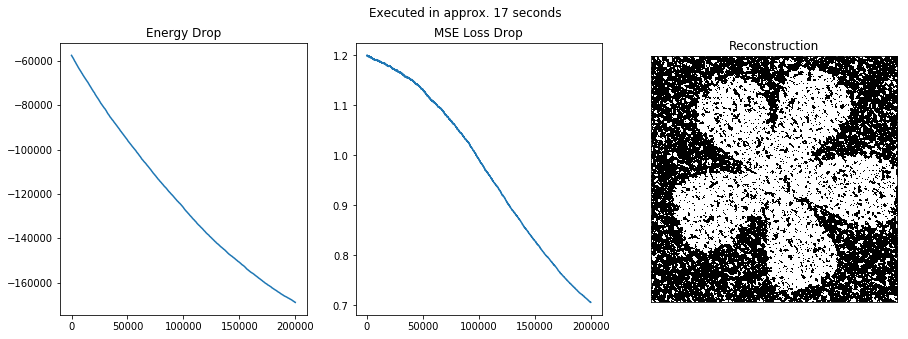

In [686]:
evaluate(your_method, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 1, "linear")

/Users/lorenz/miniconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in exp


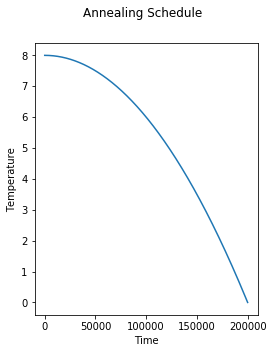

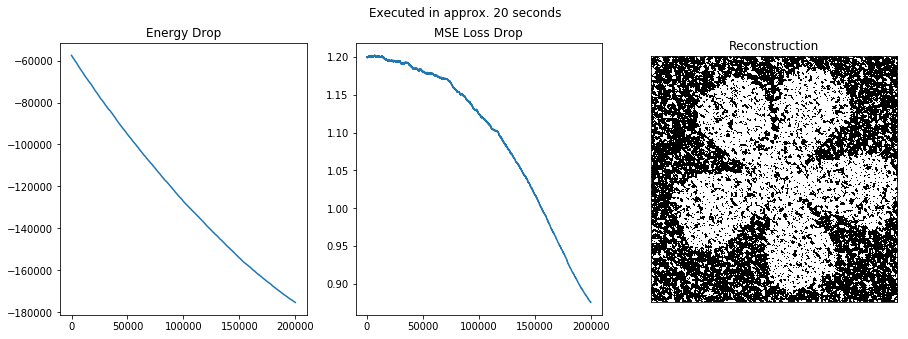

In [687]:
evaluate(your_method, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 1, "quadratic")

/Users/lorenz/miniconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars


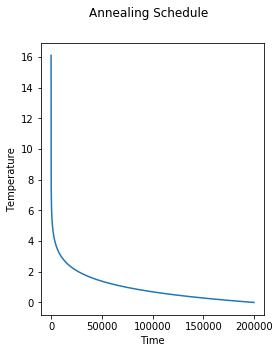

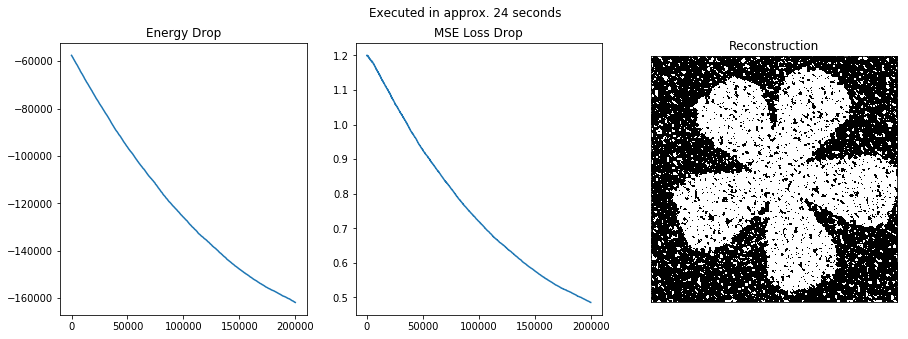

In [688]:
evaluate(your_method, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 1, "logarithmic")

# Extension: sampling from expectations

Solve this for an additional point. Note that solving only this part will give you 0 points, so you need to solve previous problems before doing this one.

## Task

In the image reconstruction problem above we have been trying to identify state with minimal energy i.e. the maximum a posteriori probability.

Another application of MCMC is to compute the expected value of a random variable - as for instance in Restricted Boltzmann Machines (RBMs), which allow for efficient Gibbs Sampling. Please refer to [3] for more details about them, even the code is provided. RBMs played a crucial role in the early development of deep learning (early as 2006 early).

We ask you to implement an RBM using the MNIST data set from last time and apply Locally Linear embedding to the representations obtained from the RBM. Does your embedding get better? You may also try to stack RBMs as described in the reference and see how the embedding changes as you get higher level representations.

It is enough to provide and explain several plots to compare the quality of embeddings of LLE and RBM+LLE models. You may use the sklearn implementation of LLE in case you skipped the previous exercise.

### References

[3] http://deeplearning.net/tutorial/rbm.html

# Extra Comments?

If there is anything that you liked or disliked in this exercise, please let us now by noting that down in the following box. This will help us improve our future exercises. Thank you in advance!